In [1]:
!pip install split-folders
import warnings
warnings.filterwarnings('ignore')
import os    
import time
import torch 
import random 
import pathlib 
import torchvision     
import numpy as np  
import pandas as pd 
import splitfolders 
import torch.nn as nn   
import seaborn as sns   
import torch.utils.data
from tabulate import tabulate
from datetime import datetime  
from termcolor import colored  
import matplotlib.pyplot as plt  
from IPython.display import display
import torchvision.transforms as transforms
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('whitegrid')

In [2]:
dir1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
# Train, Test & Validation Sets
splitfolders.ratio(
    input=dir1, output='imgs', seed=42, ratio=(0.7, 0.15, 0.15))
# Path of splited sets
dir2 = '/kaggle/working/imgs'
dir2 = pathlib.Path(dir2)

Copying files: 75000 files [06:37, 188.74 files/s]


In [3]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((250,250)),
        transforms.ToTensor(),
        transforms.Normalize((0),(1))])

In [4]:
# Set the batch size for data loading
batch_size = 32

# Define a transformation that converts images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    # Add any other transformations here (e.g., normalization)
])

# Read train images as a dataset
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'train'), transform=transform
)
# Create a Data Loader for training data
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)

# Print the training dataset information
print(colored('Train Folder:\n', 'cyan'))  # Header for train data
print(train_ds)  # Output the training dataset details


# Read validation images as a dataset
val_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'val'), transform=transform 
)
# Create a Data Loader for validation data
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True
)

# Print the validation dataset information
print(colored('Validation Folder:\n', 'cyan'))  # Header for validation data
print(val_ds)  # Output the validation dataset details

# Read test images as a dataset
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(dir2, 'test'), transform=transform 
)
# Create a Data Loader for test data
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=True
)

# Print the test dataset information
print(colored('Test Folder:\n', 'cyan'))  # Header for test data
print(test_ds)  # Output the test dataset details

Train Folder:

Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /kaggle/working/imgs/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Validation Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Test Folder:

Dataset ImageFolder
    Number of datapoints: 11250
    Root location: /kaggle/working/imgs/test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [6]:
# Defining a dictionary to map label indices to corresponding rice variety names
rice_variety_labels = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag"}

# Each key represents a unique label, and the value corresponds to the rice variety name
# This mapping will be used to interpret the predictions or label the data accordingly

In [7]:
# Extract the first batch of images and labels from the training data loader for plotting purposes
for batch_images, labels in train_loader:
    break  # We only need the first batch for visualization or further processing

# Display the labels of the first batch
print('Labels:', labels)

# Determine and print the number of unique classes in this batch
unique_classes = len(set(labels.numpy()))
print(f'Total Number of Classes in this Batch: {unique_classes}')

Labels: tensor([4, 4, 0, 0, 1, 2, 2, 3, 4, 2, 0, 1, 0, 2, 0, 1, 2, 1, 4, 2, 2, 4, 1, 1,
        0, 2, 2, 0, 4, 1, 3, 2])
Total Number of Classes in this Batch: 5


In [8]:
# Initialize an empty list to store image paths and their corresponding class labels
image_data = []

# Iterate through each dataset split (train, val, test)
for dataset_type in ['train', 'val', 'test']:
    dataset_dir = dir2 / dataset_type  # Construct the path to the dataset directory

    # Iterate through each class directory within the current dataset type
    for class_name in os.listdir(dataset_dir):
        class_dir = dataset_dir / class_name  # Construct the full path to the class directory
        image_files = os.listdir(class_dir)  # List all image files in the class directory

        # Loop through each image file and append its path and associated class label to the list
        for image_file in image_files:
            image_path = class_dir / image_file  # Construct the full image file path
            image_data.append((str(image_path), class_name))  # Append the path and label as a tuple to the list

# Convert the list of tuples into a pandas DataFrame for easier handling
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows to randomize the order of images
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame for verification
display(df.head())

,path,label
0,/kaggle/working/imgs/test/Jasmine/Jasmine (389...,Jasmine
1,/kaggle/working/imgs/train/Jasmine/Jasmine (38...,Jasmine
2,/kaggle/working/imgs/val/Arborio/Arborio (1203...,Arborio
3,/kaggle/working/imgs/train/Basmati/basmati (13...,Basmati
4,/kaggle/working/imgs/train/Basmati/basmati (40...,Basmati


In [9]:
# Define a custom Convolutional Neural Network (CNN) class
class CNN(nn.Module):
    def __init__(self, unique_classes):
        super(CNN, self).__init__()
        
        # Convolutional Layers (Feature Extractors)
        self.conv_layers = nn.Sequential(
            # First Convolutional Layer: Input channels = 3 (RGB), Output channels = 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function to introduce non-linearity
            nn.MaxPool2d(kernel_size=(2, 2)),  # Reduce spatial dimensions by half
            nn.BatchNorm2d(32),  # Normalize the outputs of the previous layer
            
            # Second Convolutional Layer: Input channels = 32, Output channels = 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(64),  # Normalize the outputs of the previous layer
            
            # Third Convolutional Layer: Input channels = 64, Output channels = 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),  # Apply ReLU activation function
            nn.MaxPool2d(kernel_size=(2, 2)),  # Further reduce spatial dimensions
            nn.BatchNorm2d(128),  # Normalize the outputs of the previous layer
        )
        

        
        # Fully Connected (Dense) Layers (Classifier)
        self.dense_layers = nn.Sequential(
            nn.Linear(107648, 128),  # Fully connected layer: From flattened features to 128 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Dropout(0.5),
            nn.Linear(128, 64),  # Fully connected layer: From 128 units to 64 units
            nn.ReLU(),  # Apply ReLU activation function
            nn.Linear(64, unique_classes)  # Final layer: From 64 units to the number of classes (e.g., 5 for this model)
        )
    
    # Define the forward pass of the network
    def forward(self, X):
        out = self.conv_layers(X)  # Pass input through the convolutional layers
        out = out.view(out.size(0), -1)  # Flatten the output from the convolutional layers
        out = self.dense_layers(out)  # Pass the flattened output through the dense layers
        return out  # Return the final output (logits or class scores)

# Instantiate the model with the desired number of classes
model = CNN(unique_classes)
dgpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Move the model to the specified device (e.g., GPU if available)
model.to(dgpu)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=107648, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, ou

In [10]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs for training
num_epochs = 5

# Initialize arrays to store loss and accuracy for each epoch
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)
train_accs = np.zeros(num_epochs)
val_accs = np.zeros(num_epochs)

# Training loop over the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    t0 = datetime.now()
    
    train_loss = []
    val_loss = []
    n_correct_train = 0
    n_total_train = 0

    # Training phase
    for images, labels in train_loader:
        # Move images and labels to the device (GPU or CPU)
        images = images.to(dgpu)
        labels = labels.to(dgpu)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: Compute predicted labels by passing images to the model
        y_pred = model(images)
        loss = criterion(y_pred, labels)  # Compute the loss

        # Backward pass: Compute gradients
        loss.backward()
        optimizer.step()

        # Store the training loss
        train_loss.append(loss.item())

        # Compute training accuracy
        _, predicted_labels = torch.max(y_pred, 1)
        n_correct_train += (predicted_labels == labels).sum().item()
        n_total_train += labels.shape[0]

    train_loss = np.mean(train_loss)
    train_losses[epoch] = train_loss
    train_accs[epoch] = n_correct_train / n_total_train

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    n_correct_val = 0
    n_total_val = 0
    with torch.no_grad():  # No need to track gradients during validation
        for images, labels in val_loader:
            images = images.to(dgpu)
            labels = labels.to(dgpu)

            # Forward pass: Compute predicted labels for validation set
            y_pred = model(images)
            loss = criterion(y_pred, labels)

            # Store the validation loss
            val_loss.append(loss.item())

            # Compute validation accuracy
            _, predicted_labels = torch.max(y_pred, 1)
            n_correct_val += (predicted_labels == labels).sum().item()
            n_total_val += labels.shape[0]

    val_loss = np.mean(val_loss)
    val_losses[epoch] = val_loss
    val_accs[epoch] = n_correct_val / n_total_val
    duration = datetime.now() - t0

    # Print the metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accs[epoch]:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accs[epoch]:.4f} | '
          f'Duration: {duration}')

# Optionally, save the model after training
torch.save(model.state_dict(), "rice_classification_model.pth")

Epoch [1/5] - Train Loss: 0.2501, Train Accuracy: 0.9164 | Val Loss: 0.0635, Val Accuracy: 0.9826 | Duration: 0:02:38.123854
Epoch [2/5] - Train Loss: 0.0784, Train Accuracy: 0.9770 | Val Loss: 0.0298, Val Accuracy: 0.9915 | Duration: 0:02:30.031831
Epoch [3/5] - Train Loss: 0.0581, Train Accuracy: 0.9829 | Val Loss: 0.0251, Val Accuracy: 0.9933 | Duration: 0:02:27.392143
Epoch [4/5] - Train Loss: 0.0494, Train Accuracy: 0.9854 | Val Loss: 0.0287, Val Accuracy: 0.9918 | Duration: 0:02:27.733488
Epoch [5/5] - Train Loss: 0.0521, Train Accuracy: 0.9862 | Val Loss: 0.0480, Val Accuracy: 0.9840 | Duration: 0:02:28.073196


In [11]:
# Create a dictionary to store the training and validation metrics
history = {
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accs,
    'Validation_Accuracy': val_accs,
    'Duration': duration
}

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(history)

# Display the DataFrame as a table with headers and in 'psql' format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------------+-------------------+------------------+-----------------------+------------------------+
|    |   Train_Loss |   Validation_Loss |   Train_Accuracy |   Validation_Accuracy | Duration               |
|----+--------------+-------------------+------------------+-----------------------+------------------------|
|  0 |    0.250052  |         0.063501  |         0.916362 |              0.982578 | 0 days 00:02:28.073196 |
|  1 |    0.0784469 |         0.0298287 |         0.976971 |              0.991467 | 0 days 00:02:28.073196 |
|  2 |    0.0580887 |         0.0251313 |         0.982914 |              0.993333 | 0 days 00:02:28.073196 |
|  3 |    0.0494436 |         0.0286984 |         0.985371 |              0.991822 | 0 days 00:02:28.073196 |
|  4 |    0.0520634 |         0.04796   |         0.98621  |              0.984    | 0 days 00:02:28.073196 |
+----+--------------+-------------------+------------------+-----------------------+------------------------+


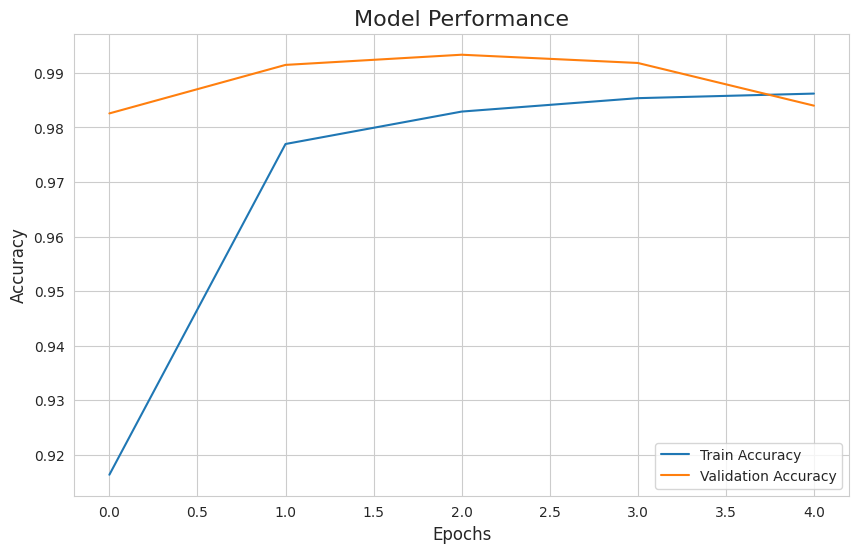

In [21]:
x = np.arange(len(result_df))

plt.figure(figsize=(10, 6))
plt.title('Model Performance', fontsize=16)

# Plot Accuracy
plt.plot(x, result_df.Train_Accuracy, label='Train Accuracy')
plt.plot(x, result_df.Validation_Accuracy, label='Validation Accuracy')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(['Train Accuracy','Validation Accuracy'])

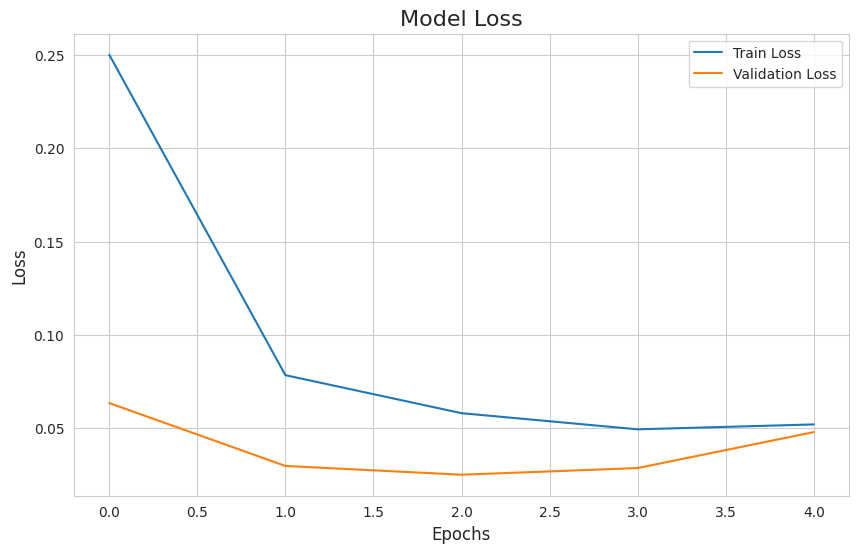

In [24]:
x = np.arange(len(result_df))

plt.figure(figsize=(10, 6))
plt.title('Model Loss', fontsize=16)

# Plot Loss
plt.plot(x, result_df.Train_Loss, label='Train Loss')
plt.plot(x, result_df.Validation_Loss, label='Validation Loss')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add the legend for loss
plt.legend(['Train Loss', 'Validation Loss'])

# Display the plot
plt.show()


In [25]:
# Evaluate the model on the test set without calculating gradients
with torch.no_grad():
    model.eval()
    start_time = datetime.now()
    test_loss = []
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        # Move images and labels to the GPU
        images = images.to(dgpu)
        labels = labels.to(dgpu)

        # Forward pass to get predictions
        predictions = model(images)
        loss = criterion(predictions, labels)

        # Append loss to test_loss list
        test_loss.append(loss.item())

        # Calculate number of correct predictions
        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    # Compute average test loss and accuracy
    avg_test_loss = np.mean(test_loss)
    test_accuracy = total_correct / total_samples
    elapsed_time = datetime.now() - start_time

    # Print the results with custom formatting
    print(colored(f'Loss: {avg_test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nDuration: {elapsed_time}', 'cyan'))

Loss: 0.0482
Accuracy: 0.9841
Duration: 0:00:17.736366


In [17]:
# model_on_device = model.to(dgpu)

# true_labels_list = []
# predicted_labels_list = []

# for batch_images, batch_labels in test_loader:
#     batch_images = batch_images.to(dgpu)
#     batch_labels = batch_labels.numpy()
#     output_predictions = model_on_device(batch_images)
#     _, predicted_batch_labels = torch.max(output_predictions.data, 1)
#     predicted_batch_labels = predicted_batch_labels.detach().cpu().numpy()
#     true_labels_list = np.append(true_labels_list, batch_labels)
#     predicted_labels_list = np.append(predicted_labels_list, predicted_batch_labels)

In [26]:
model = model.to(dgpu)
y_true = []
y_pred = []
for images, labels in test_loader:
    images = images.to(dgpu)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      2250
         1.0       1.00      0.99      0.99      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.99      1.00      0.99      2250
         4.0       1.00      0.94      0.97      2250

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250

